In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sympy import *

In [2]:
# Download datasets
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt" #Train Dataset of NSL-KDD Dataset
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"   #Test dataset of NSL-KDD Dataset

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(filename):
    print("Downloading 10% KDD Cup'99 dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(train_file):
    print("Downloading training dataset of NSL-KDD...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset of NSL-KDD...")
    urlretrieve(test_url, test_file)
# print('Datasets have been downloaded.')

In [3]:
class IntrusionDetectionNN(nn.Module):
    def __init__(self, input_size):
        super(IntrusionDetectionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [4]:
# Define a wrapper for PyTorch model to be used in GridSearchCV
class TorchNNClassifier(BaseEstimator, ClassifierMixin):
        def __init__(self, input_size, lr=0.001, epochs=10, batch_size=64, threshold=0.5, verbose=False, device='cpu'):
            self.input_size = input_size
            self.lr = lr
            self.epochs = epochs
            self.batch_size = batch_size
            self.threshold = threshold
            self.verbose = verbose
            self.device = device  # Add device attribute
            self._build_model()

        def _build_model(self):
            self.model = IntrusionDetectionNN(self.input_size).to(self.device)  # Move model to device
            self.criterion = nn.BCELoss()
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        def fit(self, X, y):
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device) #move to device
            #Reshape y to be a 1D array
            y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32).to(self.device) #move to device
            dataset = TensorDataset(X_tensor, y_tensor)
            loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
            # ... (rest of your code) ...
            self._build_model()  # Reset weights
            for epoch in range(self.epochs):
                total_loss = 0
                for batch_X, batch_y in loader:
                    self.optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item()
                if self.verbose:
                    print(f"Epoch {epoch+1}/{self.epochs}, Loss: {total_loss / len(loader):.4f}")
            return self

        def predict(self, X):
            with torch.no_grad():
                X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device) #move to device
                outputs = self.model(X_tensor).cpu().numpy() # Move to cpu before returning
            return (outputs >= self.threshold).astype(float).ravel()

        def predict_proba(self, X):
            with torch.no_grad():
                X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device) #move to device
                outputs = self.model(X_tensor).cpu().numpy() # Move to cpu before returning
            return outputs

In [5]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [6]:
def calculateAndDisplayEvaluationMetrics(y_test, y_pred,title):
    accuracy = accuracy_score(y_test,y_pred)*100
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plot_confusion_matrix(y_test, y_pred, title)

In [9]:
# (a) KDD Cup '99

#defining columns
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
df = df.drop_duplicates()

print(df.shape)

(145586, 42)


In [10]:
print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a
#Clearly, we can see that this daataset is very skewed and imbalanced

{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [12]:
#preproccesing data
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Convert labels to binary: 0 for normal, 1 for attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

# Extract features and labels
X = df.drop("label", axis=1).values
y = df["label"].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [14]:
#Connecting to GPU
input_size = X_train.shape[1] # Calculate the input size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntrusionDetectionNN(input_size).to(device) # assuming IntrusionDetectionNN is your model class

# Move input data to GPU
X_train_tensor = X_train_tensor.to(device)
y_train_tensor= y_train_tensor.to(device)

X_test_tensor = X_train_tensor.to(device)
y_test_tensor= y_train_tensor.to(device)

In [17]:
#Define parameter grid
param_grid = {
    'lr': [0.0001, 0.001, 0.005],
    'threshold': [i/100 for i in range(30, 71, 10)],  # Tune threshold from 0.30 to 0.70
}

## Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize classifier for GridSearch, passing device
torch_clf = TorchNNClassifier(input_size=X_train.shape[1], epochs=10, device=device)

# Use GridSearchCV with F1 scorer
scorer = make_scorer(f1_score)
grid_search = GridSearchCV(estimator=torch_clf, param_grid=param_grid, scoring=scorer, cv=3, verbose=1)

# Convert data to tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

# Fit the GridSearchCV with data on the device
grid_search.fit(X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy())  # Convert tensors back to NumPy for GridSearchCV

# Get best model
best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters: {'lr': 0.001, 'threshold': 0.4}
Best CV F1 Score: 0.9962


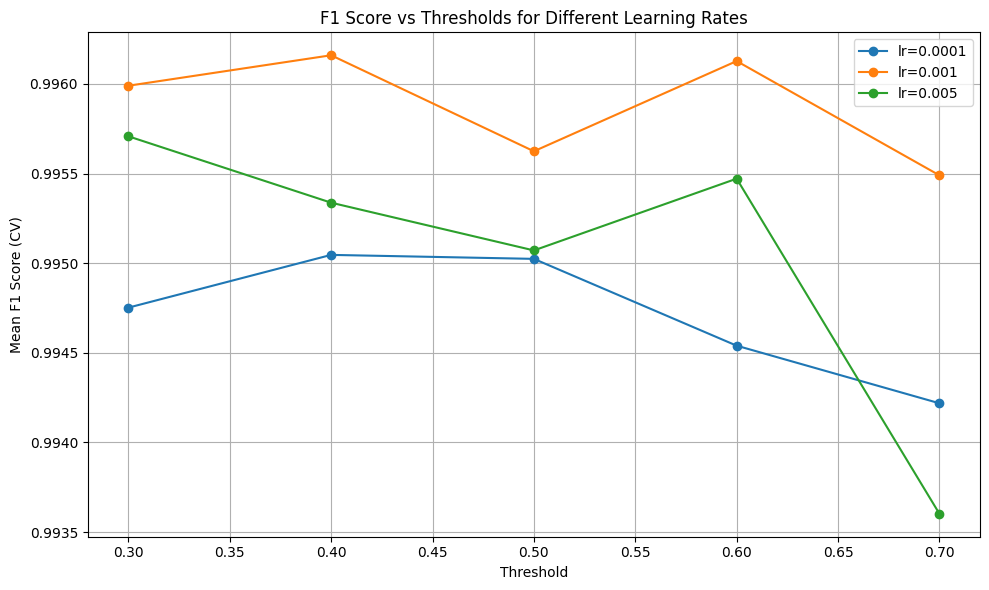

In [18]:
# Extract F1 scores and parameters
results = grid_search.cv_results_
scores = results['mean_test_score']
lrs = [params['lr'] for params in results['params']]
thresholds = [params['threshold'] for params in results['params']]

# Plot
plt.figure(figsize=(10, 6))
for lr in sorted(set(lrs)):
    xs = [t for l, t in zip(lrs, thresholds) if l == lr]
    ys = [s for l, s, t in zip(lrs, scores, thresholds) if l == lr]
    plt.plot(xs, ys, marker='o', label=f'lr={lr}')

plt.xlabel('Threshold')
plt.ylabel('Mean F1 Score (CV)')
plt.title('F1 Score vs Thresholds for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training Set Evaluation
Model Accuracy: 99.66%
Precision: 0.9980
Recall: 0.9935
F1 Score: 0.9958


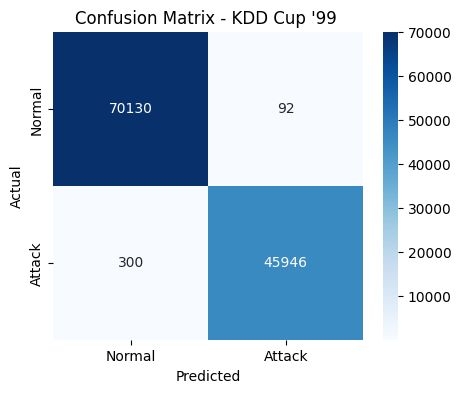


Test Set Evaluation
Model Accuracy: 99.70%
Precision: 0.9976
Recall: 0.9950
F1 Score: 0.9963


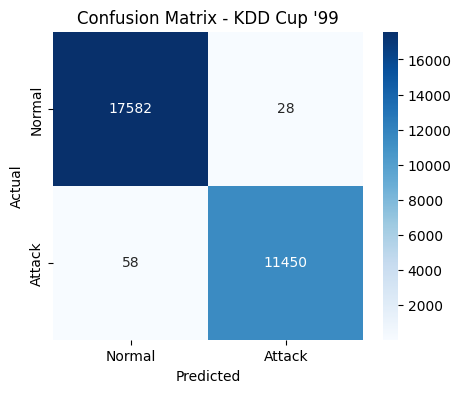

In [19]:
# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Predictions using the retrained best model
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Evaluation
print("\nTraining Set Evaluation")
calculateAndDisplayEvaluationMetrics(y_train, train_preds, "Confusion Matrix - KDD Cup '99 ")

print("\nTest Set Evaluation")
calculateAndDisplayEvaluationMetrics(y_test, test_preds, "Confusion Matrix - KDD Cup '99")

In [7]:
#(b) ON the NSL-KDD Dataset
KDDNSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]

train_df = pd.read_csv(train_file, names=KDDNSL_columns, header=None)
test_df = pd.read_csv(test_file, names=KDDNSL_columns, header=None)

#Dropping the difficulty column as its irrelevant for training
train_df.drop("difficulty", axis=1, inplace=True)
test_df.drop("difficulty", axis=1, inplace=True)

print(train_df['class'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a
#Clearly, we can see that this daataset is more balanced

# Label encode categorical columns(to convert features to numerical values)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()

for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])  # Fit + transform on train
    test_df[col] = encoder.transform(test_df[col])  # Transform only on test (NO FIT)

# Convert class labels to binary (0 for normal, 1 for attack)
train_df["class"] = train_df["class"].apply(lambda x: 0 if x == "normal" else 1)
test_df["class"] = test_df["class"].apply(lambda x: 0 if x == "normal" else 1)

# Split features and labels
X_train = train_df.drop("class", axis=1).values
y_train = train_df["class"].values
X_test = test_df.drop("class", axis=1).values
y_test = test_df["class"].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

{'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}
(125973, 41)
(22544, 41)


In [8]:
# Convert test data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [9]:
#Connecting to GPU
input_size = X_train.shape[1] # Calculate the input size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntrusionDetectionNN(input_size).to(device) # assuming IntrusionDetectionNN is your model class

# Move input data to GPU
X_train_tensor = X_train_tensor.to(device)
y_train_tensor= y_train_tensor.to(device)

X_test_tensor = X_train_tensor.to(device)
y_test_tensor= y_train_tensor.to(device)

In [13]:
#Define parameter grid
param_grid = {
    'lr': [0.0001, 0.001, 0.005],
    'threshold': [i/100 for i in range(30, 71, 5)],  # Tune threshold from 0.30 to 0.70
}

## Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize classifier for GridSearch, passing device
torch_clf = TorchNNClassifier(input_size=X_train.shape[1], epochs=10, device=device)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use GridSearchCV with F1 scorer
scorer = make_scorer(f1_score)
grid_search = GridSearchCV(estimator=torch_clf, param_grid=param_grid, scoring=scorer, cv=skf, verbose=1)

# Convert data to tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

# Fit the GridSearchCV with data on the device
grid_search.fit(X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy())  # Convert tensors back to NumPy for GridSearchCV

# Get best model
best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'lr': 0.001, 'threshold': 0.5}
Best CV F1 Score: 0.9910


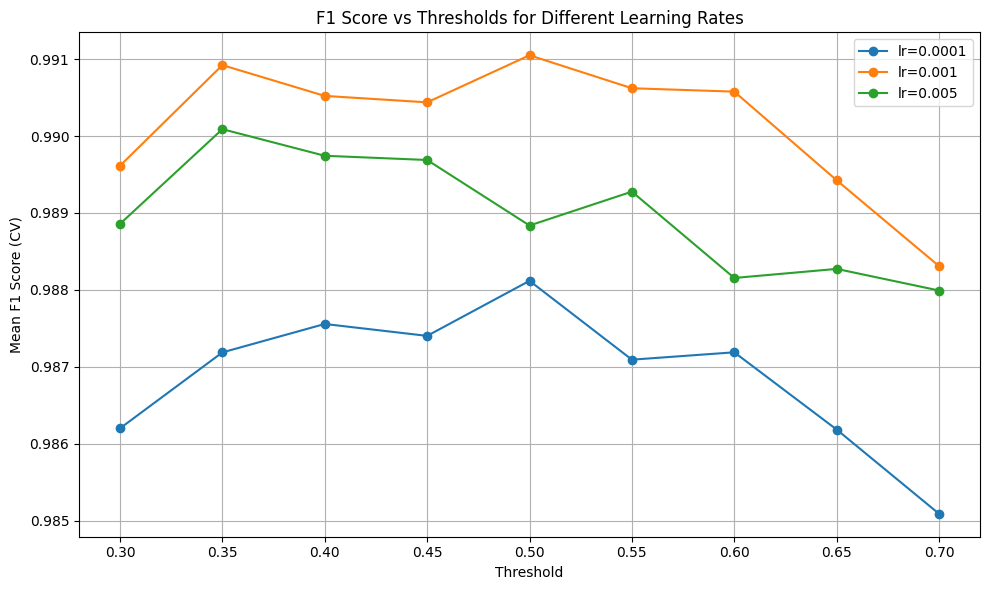

In [14]:
# Extract F1 scores and parameters
results = grid_search.cv_results_
scores = results['mean_test_score']
lrs = [params['lr'] for params in results['params']]
thresholds = [params['threshold'] for params in results['params']]

# Plot
plt.figure(figsize=(10, 6))
for lr in sorted(set(lrs)):
    xs = [t for l, t in zip(lrs, thresholds) if l == lr]
    ys = [s for l, s, t in zip(lrs, scores, thresholds) if l == lr]
    plt.plot(xs, ys, marker='o', label=f'lr={lr}')

plt.xlabel('Threshold')
plt.ylabel('Mean F1 Score (CV)')
plt.title('F1 Score vs Thresholds for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training Set Evaluation
Model Accuracy: 99.23%
Precision: 0.9943
Recall: 0.9892
F1 Score: 0.9917


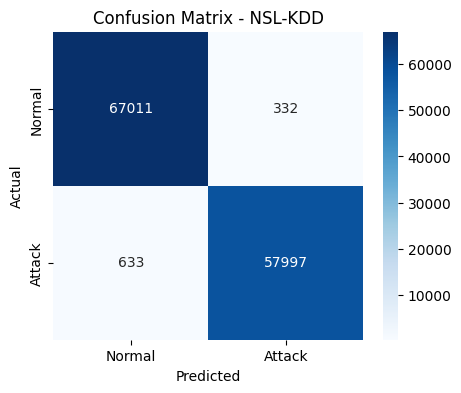


Test Set Evaluation
Model Accuracy: 79.98%
Precision: 0.9750
Recall: 0.6653
F1 Score: 0.7909


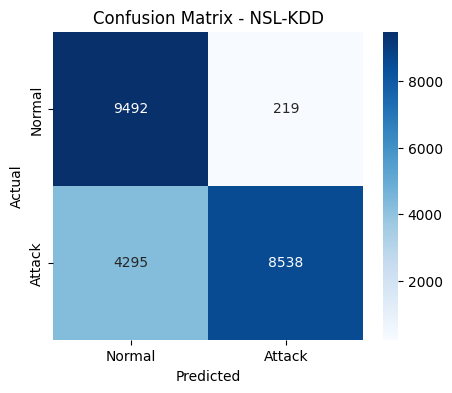

In [15]:
# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Predictions using the retrained best model
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Evaluation
print("\nTraining Set Evaluation")
calculateAndDisplayEvaluationMetrics(y_train, train_preds, "Confusion Matrix - NSL-KDD")

print("\nTest Set Evaluation")
calculateAndDisplayEvaluationMetrics(y_test, test_preds, "Confusion Matrix - NSL-KDD")